<a href="https://colab.research.google.com/github/ads-22/Cyclone-Intensity-/blob/main/Final_2_38_Minor2_first.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DRIVE 
MOUNT

In [ ]:
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import tarfile

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pwd
os.chdir('/content/gdrive/MyDrive/Minor 2')
!pwd

/content/gdrive/My Drive/Minor 2
/content/gdrive/MyDrive/Minor 2


**DOWNLOAD**

In [ ]:
def download_hursat(years):
    best_track_data = pd.read_csv('besttrack.csv')
     
    for year in years:
        year_directory_url = 'https://www.ncei.noaa.gov/data/hurricane-satellite-hursat-b1/archive/v06/' + year
        year_directory_page = requests.get(year_directory_url).text
        year_directory_soup = BeautifulSoup(year_directory_page, 'html.parser')
        year_directory_file_urls = [year_directory_url + '/' + node.get('href') 
                                    for node in year_directory_soup.find_all('a') if node.get('href').endswith('tar.gz')]
        print('\n' + year + ' file loaded.')

        files_processed = 0
        for storm_file_url in year_directory_file_urls:
            storm_name = storm_file_url.split('_')[-2]
            year = int(storm_file_url.split('_')[3][:4])
            file_has_match_in_best_track = not best_track_data.loc[
                (best_track_data['year'] == year) & (best_track_data['storm_name'] == storm_name)
            ].empty

            if file_has_match_in_best_track:
                file_name = storm_file_url.split('/')[-1]
                storm_file_path = 'Satellite Imagery/' + file_name

                if not os.path.exists('Satellite Imagery'):
                    os.makedirs('Satellite Imagery')

                request = requests.get(storm_file_url, allow_redirects=True)
                open(storm_file_path, 'wb').write(request.content)
                request.close()

                tar = tarfile.open(storm_file_path)
                file_prefixes_in_directory = []
                for file_name in tar.getnames():
                    fulldate = file_name.split(".")[2] + file_name.split(".")[3] + file_name.split(".")[4]
                    time = file_name.split(".")[5]
                    satellite = file_name.split(".")[7][:3]

                    file_has_match_in_best_track = not best_track_data.loc[
                        (best_track_data['fulldate'] == int(fulldate)) & (best_track_data['time'] == int(time))].empty
                    is_redundant = '.'.join(file_name.split('.')[:6]) in file_prefixes_in_directory

                    if file_has_match_in_best_track and not is_redundant and satellite == "GOE":
                        f = tar.extractfile(file_name)
                        open('Satellite Imagery/' + file_name, 'wb').write(f.read())
                        file_prefixes_in_directory.append('.'.join(file_name.split('.')[:6]))

                tar.close()
                os.remove(storm_file_path)

            files_processed += 1
            print_progress('Processing Files for ' + str(year), files_processed, len(year_directory_file_urls))

In [ ]:
def print_progress(action, progress, total):
    percent_progress = round((progress / total) * 100, 1)
    print(action + '... ' + str(percent_progress) + '% (' + str(progress) + ' of ' + str(total) + ')')


In [ ]:
YEARS_TO_DOWNLOAD = ['2016', '2015', '2014', '2013', '2012']
download_hursat(YEARS_TO_DOWNLOAD)


2016 file loaded.


KeyboardInterrupt: ignored

## **ASSEMBLE**

In [ ]:
import pandas as pd
import numpy as np
import os
import netCDF4
best_track_data = pd.read_csv('besttrack.csv')
side_length = 50

images = []
labels = []
files = os.listdir('Satellite Imagery')
num_files = len(files)

for i in range(len(files)):
    raw_data = netCDF4.Dataset('Satellite Imagery/' + files[i])
    ir_data = raw_data.variables['IRWIN'][0]

    south_bound = (ir_data.shape[0] - side_length) // 2
    north_bound = south_bound + side_length
    cropped_ir_data = ir_data[south_bound:north_bound]
    west_bound = (ir_data.shape[1] - side_length) // 2
    east_bound = side_length
    cropped_ir_data = np.delete(cropped_ir_data, np.s_[:west_bound], axis=1)
    cropped_ir_data = np.delete(cropped_ir_data, np.s_[east_bound:], axis=1)

    file_name = files[i]
    file_name = file_name.split('.')
    storm_name = file_name[1]
    date = int(file_name[2] + file_name[3] + file_name[4])
    time = int(file_name[5])

    matching_best_track_data = best_track_data.loc[
        (best_track_data.storm_name == storm_name) &
        (best_track_data.fulldate == date) &
        (best_track_data.time == time)
    ]

    try:
        wind_speed = matching_best_track_data.max_sus_wind_speed.reset_index(drop=True)[0]
    except Exception:
        print('\rCould not find label for image of ' + storm_name + ' at date ' + str(date) + ' and time ' + str(time), end='\n')
        continue  

    images.append(cropped_ir_data)
    labels.append(wind_speed)

    raw_data.close()

    print('\rProcessing Samples... ' + str(round(((i + 1) / num_files) * 100, 1)) + '% (' + str(i + 1) + ' of ' + str(
        num_files) + ')', end='')

print('\nSaving NumPy arrays...')

images = np.array(images)
labels = np.array(labels)
images = images.reshape((images.shape[0], side_length, side_length, 1))
np.save('images.npy', images)
np.save('labels.npy', labels)

print("\nNumPy files saved. Processing complete.")


Processing Samples... 0.5% (29 of 5625)

KeyboardInterrupt: ignored

In [ ]:
def read_and_prepare_data(validation_mode, k=5, augment=True):

    if validation_mode == 'k_fold':
        images = np.load('images.npy')
        labels = np.load('labels.npy')
        folded_images = []
        folded_labels = []
        for i in range(k):
            start = int((i / k) * len(images))
            end = int(((i + 1) / k) * len(images))
            folded_images.append(images[start:end])
            folded_labels.append(labels[start:end])
        folded_augmented_images = []
        folded_augmented_labels = []
        for i in range(k):
            if augment:
                print('\nAugmenting Fold ' + str(i + 1) + ' of ' + str(k))
                augmented_images, augmented_labels = augment_images(folded_images[i], folded_labels[i])
                folded_augmented_images.append(augmented_images)
                folded_augmented_labels.append(augmented_labels)
        train_images = []
        train_labels = []
        test_images = []
        test_labels = []
        for i in range(k):
            train_images.append(np.concatenate(folded_images[:i] + folded_images[(i+1):]))
            train_labels.append(np.concatenate(folded_labels[:i] + folded_labels[(i+1):]))
            if augment:
                train_images[i] = np.concatenate(([train_images[i]] + folded_augmented_images[:i] + folded_augmented_images[(i + 1):]))
                train_labels[i] = np.concatenate(([train_labels[i]] + folded_augmented_labels[:i] + folded_augmented_labels[(i + 1):]))
            test_images.append(folded_images[i])
            test_labels.append(folded_labels[i])
            train_images[i], test_images[i] = standardize_data(train_images[i], test_images[i])

        return train_images, train_labels, test_images, test_labels

In [ ]:
def standardize_data(train_images, test_images):
    train_images[train_images < 0] = 0
    test_images[test_images < 0] = 0
    st_dev = np.std(train_images)
    mean = np.mean(train_images)
    train_images = np.divide(np.subtract(train_images, mean), st_dev)
    test_images = np.divide(np.subtract(test_images, mean), st_dev)
    return train_images, test_images

In [ ]:
def augment_images(images, labels):
    from keras.preprocessing import image
    flip_generator = image.ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True
    )
    rotate_generator = image.ImageDataGenerator(
        rotation_range=360,
        fill_mode='nearest'
    )
    augmented_images = []
    augmented_labels = []

    for i in range(len(images)):

        image = np.reshape(images[i], (1, images[i].shape[0], images[i].shape[1], 1))
        label = labels[i]

        num_new_images = 0
        if 50 < label < 75:
            for batch in flip_generator.flow(image, batch_size=1):
                new_image = np.reshape(batch[0], (batch[0].shape[0], batch[0].shape[1], 1))
                augmented_images.append(new_image)
                augmented_labels.append(label)
                num_new_images += 1
                if num_new_images == 2:
                    break
        elif 75 < label < 100:
            for batch in rotate_generator.flow(image, batch_size=1):
                new_image = np.reshape(batch[0], (batch[0].shape[0], batch[0].shape[1], 1))
                augmented_images.append(new_image)
                augmented_labels.append(label)
                num_new_images += 1
                if num_new_images == 6:
                    break

        elif 100 <= label:
            for batch in rotate_generator.flow(image, batch_size=1):
                new_image = np.reshape(batch[0], (batch[0].shape[0], batch[0].shape[1], 1))
                augmented_images.append(new_image)
                augmented_labels.append(label)
                num_new_images += 1
                if num_new_images == 12:
                    break

        print_progress('Augmenting Images', i + 1, len(images))
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    return augmented_images, augmented_labels

In [ ]:
def category_of(wind_speed):
    if wind_speed <= 33:
        return 'T. Depression'
    elif wind_speed <= 64:
        return 'T. Storm'
    elif wind_speed <= 83:
        return 'Category 1'
    elif wind_speed <= 95:
        return 'Category 2'
    elif wind_speed <= 113:
        return 'Category 3'
    elif wind_speed <= 134:
        return 'Category 4'
    else:
        return 'Category 5'

In [ ]:
AUGMENT = True
NUM_FOLDS = 5

In [ ]:
train_images, train_labels, test_images, test_labels = read_and_prepare_data('k_fold', NUM_FOLDS, augment=AUGMENT)

Streaming output truncated to the last 5000 lines.
Augmenting Images... 52.2% (582 of 1114)
Augmenting Images... 52.3% (583 of 1114)
Augmenting Images... 52.4% (584 of 1114)
Augmenting Images... 52.5% (585 of 1114)
Augmenting Images... 52.6% (586 of 1114)
Augmenting Images... 52.7% (587 of 1114)
Augmenting Images... 52.8% (588 of 1114)
Augmenting Images... 52.9% (589 of 1114)
Augmenting Images... 53.0% (590 of 1114)
Augmenting Images... 53.1% (591 of 1114)
Augmenting Images... 53.1% (592 of 1114)
Augmenting Images... 53.2% (593 of 1114)
Augmenting Images... 53.3% (594 of 1114)
Augmenting Images... 53.4% (595 of 1114)
Augmenting Images... 53.5% (596 of 1114)
Augmenting Images... 53.6% (597 of 1114)
Augmenting Images... 53.7% (598 of 1114)
Augmenting Images... 53.8% (599 of 1114)
Augmenting Images... 53.9% (600 of 1114)
Augmenting Images... 53.9% (601 of 1114)
Augmenting Images... 54.0% (602 of 1114)
Augmenting Images... 54.1% (603 of 1114)
Augmenting Images... 54.2% (604 of 1114)
Augmen

### Model

In [ ]:
from keras.layers import *
from keras import models
from keras import layers
from keras import metrics
from keras.callbacks import EarlyStopping

In [ ]:
def build_model():
    from keras.models import Sequential
    model = Sequential()
    model.add(Conv2D(20,(3,3), padding='same',activation='relu',input_shape=(50,50,1)))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(40,(3,3),padding='same',activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(60,(3,3),padding='same',activation='relu'))
    model.add(MaxPool2D((2,2))) 
    model.add(Conv2D(80,(3,3),padding='same',activation='relu'))

    model.add(Flatten())
    model.add(Dense(1000,activation='relu'))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(2,activation='softmax'))
    model.summary()


    model.compile(
        optimizer='rmsprop',
        loss='mse',
        metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    model.summary()
    return model



In [ ]:
def train_model(model, train_images, train_labels, test_images, test_labels, show_performance_by_epoch=False):
    performance_log = model.fit(
        train_images,
        train_labels,
        callbacks=[EarlyStopping(monitor='val_mean_absolute_error', patience=5, restore_best_weights=True)],
        epochs=10,
        batch_size=64,
        validation_data=(test_images, test_labels))

    return model

In [ ]:
AUGMENT = True
NUM_FOLDS = 5

In [ ]:
train_images, train_labels, test_images, test_labels = read_and_prepare_data('k_fold', NUM_FOLDS, augment=AUGMENT)

Streaming output truncated to the last 5000 lines.
Augmenting Images... 52.2% (582 of 1114)
Augmenting Images... 52.3% (583 of 1114)
Augmenting Images... 52.4% (584 of 1114)
Augmenting Images... 52.5% (585 of 1114)
Augmenting Images... 52.6% (586 of 1114)
Augmenting Images... 52.7% (587 of 1114)
Augmenting Images... 52.8% (588 of 1114)
Augmenting Images... 52.9% (589 of 1114)
Augmenting Images... 53.0% (590 of 1114)
Augmenting Images... 53.1% (591 of 1114)
Augmenting Images... 53.1% (592 of 1114)
Augmenting Images... 53.2% (593 of 1114)
Augmenting Images... 53.3% (594 of 1114)
Augmenting Images... 53.4% (595 of 1114)
Augmenting Images... 53.5% (596 of 1114)
Augmenting Images... 53.6% (597 of 1114)
Augmenting Images... 53.7% (598 of 1114)
Augmenting Images... 53.8% (599 of 1114)
Augmenting Images... 53.9% (600 of 1114)
Augmenting Images... 53.9% (601 of 1114)
Augmenting Images... 54.0% (602 of 1114)
Augmenting Images... 54.1% (603 of 1114)
Augmenting Images... 54.2% (604 of 1114)
Augmen

In [ ]:
model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 20)        200       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 40)        7240      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 40)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 60)        21660     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 60)         0

In [ ]:
for i in range(NUM_FOLDS):
        print('\n\nTraining Fold ' + str(i + 1) + ' of ' + str(NUM_FOLDS) + '\n')
        model = train_model(model, train_images[i], train_labels[i], test_images[i], test_labels[i])



Training Fold 1 of 5

Epoch 1/10
162/162 [==============================] - 40s 233ms/step - loss: 6271.7080 - mean_absolute_error: 71.9334 - root_mean_squared_error: 79.1941 - val_loss: 2887.3955 - val_mean_absolute_error: 47.9470 - val_root_mean_squared_error: 53.7345
Epoch 2/10
162/162 [==============================] - 38s 236ms/step - loss: 6271.7085 - mean_absolute_error: 71.9334 - root_mean_squared_error: 79.1941 - val_loss: 2887.3955 - val_mean_absolute_error: 47.9470 - val_root_mean_squared_error: 53.7345
Epoch 3/10
162/162 [==============================] - 38s 234ms/step - loss: 6271.7080 - mean_absolute_error: 71.9334 - root_mean_squared_error: 79.1941 - val_loss: 2887.3955 - val_mean_absolute_error: 47.9470 - val_root_mean_squared_error: 53.7345
Epoch 4/10
162/162 [==============================] - 37s 231ms/step - loss: 6271.7090 - mean_absolute_error: 71.9334 - root_mean_squared_error: 79.1941 - val_loss: 2887.3955 - val_mean_absolute_error: 47.9470 - val_root_mean_squ

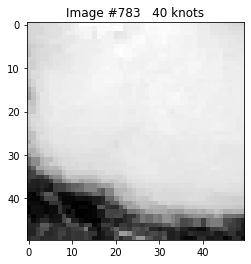

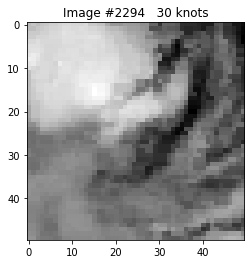

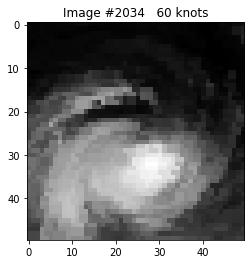

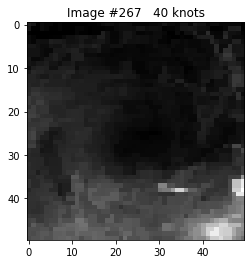

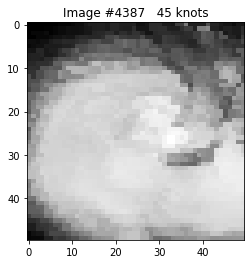

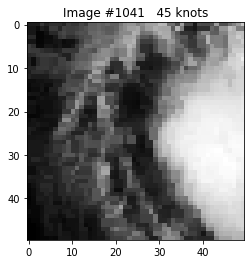

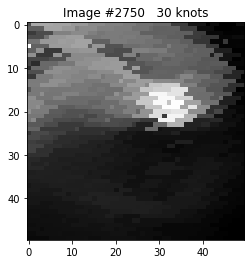

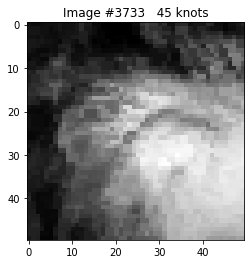

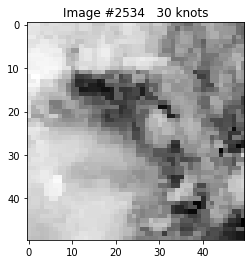

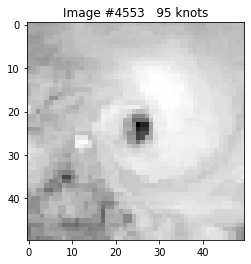

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

images = np.load('images.npy')
labels = np.load('labels.npy')

for x in range(10):
    i = random.randint(0, images.shape[0])
    image = np.reshape(images[i], (images[i].shape[0], images[i].shape[1]))
    plt.imshow(image, cmap='binary')
    plt.title('Image #' + str(i) + '   ' + str(labels[i]) + ' knots')
    plt.show()

## Build Model

In [ ]:
def build_model():

    # Build network architecture
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation=None))

    # Configure model optimization
    model.compile(
        optimizer='rmsprop',
        loss='mse',
        metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])

    return model

### Training Model

In [ ]:
def performance_by_epoch(performance_log):

    # Get metrics for each epoch after model finishes training
    train_loss = performance_log.history['loss']
    test_loss = performance_log.history['val_loss']
    train_mae = performance_log.history['mean_absolute_error']
    test_mae = performance_log.history['val_mean_absolute_error']
    epochs = range(1, len(train_loss) + 1)

    # Build a dataframe storing epoch metrics
    performance_df = pd.DataFrame(columns=['epoch', 'train_or_test', 'loss_or_mae', 'value'])
    for i in range(len(train_loss)):
        new_row = {'epoch': epochs[i], 'train_or_test': 'train', 'loss_or_mae': 'loss', 'value': train_loss[i]}
        performance_df = performance_df.append(new_row, ignore_index=True)
        new_row = {'epoch': epochs[i], 'train_or_test': 'test', 'loss_or_mae': 'loss', 'value': test_loss[i]}
        performance_df = performance_df.append(new_row, ignore_index=True)
        new_row = {'epoch': epochs[i], 'train_or_test': 'train', 'loss_or_mae': 'mae', 'value': train_mae[i]}
        performance_df = performance_df.append(new_row, ignore_index=True)
        new_row = {'epoch': epochs[i], 'train_or_test': 'test', 'loss_or_mae': 'mae', 'value': test_mae[i]}
        performance_df = performance_df.append(new_row, ignore_index=True)
    performance_df = performance_df.astype({'epoch': np.int64})

    # Plot metrics on graph, fitted with exponential decay curves
    lm = sns.lmplot(
        x='epoch',
        y='value',
        data=performance_df,
        row='loss_or_mae',
        hue='train_or_test',  # Note: If epoch = 1, this line causes an error. Make sure epoch >= 2
        logx=True,
        truncate=False,
        sharey=False)
    axes = lm.axes
    max_mae = performance_df.loc[performance_df.loss_or_mae == 'mae']['value'].max()
    min_mae = performance_df.loc[performance_df.loss_or_mae == 'mae']['value'].min()
    axes[1, 0].set_ylim(min_mae - min_mae * 0.2, max_mae + max_mae * 0.2)
    plt.show()



In [ ]:
def train_model(model, train_images, train_labels, test_images, test_labels, show_performance_by_epoch=False):

    # Run model and get metrics for each epoch
    performance_log = model.fit(
        train_images,
        train_labels,
        callbacks=[EarlyStopping(monitor='val_mean_absolute_error', patience=5, restore_best_weights=True)],
        epochs=100,
        batch_size=64,
        validation_data=(test_images, test_labels))

    if show_performance_by_epoch:
        performance_by_epoch(performance_log)

    return model

## Making Predictions

In [ ]:
def generate_predictions(model, test_images, test_labels):

    # Run validation data through model and print mean absolute error
    raw_predictions = model.predict(test_images)
    raw_predictions = raw_predictions.flatten()

    # Build a dataframe storing data for each prediction made by the model
    processed_predictions = pd.DataFrame(columns=['prediction', 'actual', 'abs_error', 'category'])
    for i in range(len(raw_predictions)):
        abs_error = abs(raw_predictions[i] - test_labels[i])
        new_row = {
            'prediction': raw_predictions[i],
            'actual': test_labels[i],
            'abs_error': abs_error,
            'abs_error_squared': abs_error ** 2,
            'category': category_of(test_labels[i])}
        processed_predictions = processed_predictions.append(new_row, ignore_index=True)
        print_progress('Processing Predictions', i + 1, len(raw_predictions))

    return processed_predictions

In [ ]:
def show_validation_results(predictions, show_plots=True, print_error=True):
    print('\n\nRESULTS')

    if print_error:
        mae = predictions['abs_error'].mean()
        print('\nMean Absolute Error: ' + str(round(float(mae), 2)) + ' knots')
        rmse = predictions['abs_error_squared'].mean() ** 0.5
        print('Root Mean Square Error: ' + str(round(float(rmse), 2)) + ' knots')

    if show_plots:
        # List of categories in order of ascending strength
        categories = ['T. Depression', 'T. Storm', 'Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5']

        # Show bar graph of median absolute error for each category
        plt.figure(figsize=(10, 5), dpi=300)
        sns.barplot(
            x='category',
            y='abs_error',
            data=predictions,
            estimator=np.median,
            order=categories)
        sns.despine()
        plt.xlabel("Hurricane Strength")
        plt.ylabel("Absolute Error")
        plt.title("Median Absolute Error in Neural Network's Predictions By Category")
        plt.savefig('median_abs_error_by_category.png')
        print('Graph of median absolute error by category saved as median_abs_error_by_category.png')
        plt.clf()

        # Show density plot of error for each category
        for category in categories:
            num_samples_tested = len(predictions.loc[predictions.category == category]['abs_error'])
            sns.distplot(
                predictions.loc[predictions.category == category]['abs_error'],
                label=category + ' (' + str(num_samples_tested) + ' samples tested)',
                hist=False,
                kde_kws={"shade": True})
            sns.despine()
        plt.xlabel("Absolute Error")
        plt.title("Distribution of Absolute Error By Category")
        plt.legend()
        plt.xlim(0, None)
        plt.ylim(0, None)
        plt.savefig('error_dist_by_category.png')
        print('Graph of error distribution by category saved as error_dist_by_category.png')

In [ ]:
predictions = pd.DataFrame(columns=['prediction', 'actual', 'abs_error', 'category'])

In [ ]:
train_images, train_labels, test_images, test_labels = read_and_prepare_data('k_fold', NUM_FOLDS, augment=AUGMENT)
model = build_model()
for i in range(NUM_FOLDS):
        print('\n\nTraining Fold ' + str(i + 1) + ' of ' + str(NUM_FOLDS) + '\n')
        model = train_model(model, train_images[i], train_labels[i], test_images[i], test_labels[i])
        kth_fold_predictions = generate_predictions(model, test_images[i], test_labels[i])
        predictions = predictions.append(kth_fold_predictions, ignore_index=True)
show_validation_results(predictions)

Streaming output truncated to the last 5000 lines.
Augmenting Images... 57.0% (635 of 1114)
Augmenting Images... 57.1% (636 of 1114)
Augmenting Images... 57.2% (637 of 1114)
Augmenting Images... 57.3% (638 of 1114)
Augmenting Images... 57.4% (639 of 1114)
Augmenting Images... 57.5% (640 of 1114)
Augmenting Images... 57.5% (641 of 1114)
Augmenting Images... 57.6% (642 of 1114)
Augmenting Images... 57.7% (643 of 1114)
Augmenting Images... 57.8% (644 of 1114)
Augmenting Images... 57.9% (645 of 1114)
Augmenting Images... 58.0% (646 of 1114)
Augmenting Images... 58.1% (647 of 1114)
Augmenting Images... 58.2% (648 of 1114)
Augmenting Images... 58.3% (649 of 1114)
Augmenting Images... 58.3% (650 of 1114)
Augmenting Images... 58.4% (651 of 1114)
Augmenting Images... 58.5% (652 of 1114)
Augmenting Images... 58.6% (653 of 1114)
Augmenting Images... 58.7% (654 of 1114)
Augmenting Images... 58.8% (655 of 1114)
Augmenting Images... 58.9% (656 of 1114)
Augmenting Images... 59.0% (657 of 1114)
Augmen

In [ ]:
test_2010_images = np.load('2010_images.npy')
test_2010_labels = np.load('2010_labels.npy')

In [ ]:
pred=generate_predictions(model, test_2010_images[1], test_2010_labels[1])
show_validation_results(pred)